In [ ]:
import numpy as np 
import pandas as pd
import math

# For Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# For preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# For training machine learning model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

# For training deep learning model
import keras
from keras.layers import Dense, LSTM, Dropout

# For evaluating models
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import math
 

# For saving models
import joblib
import pickle

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Dataset

- The data set is at 10 min for about 4.5 months. 
- The house temperature and humidity conditions were monitored with a wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods.
- The energy data was logged every 10 minutes with m-bus energy meters.
- Weather from the nearest airport weather station was downloaded from a public data set , and merged together with the experimental data sets using the date and time column. 
- Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

## Attributes

* Temperature in Celsius (T)
* Relative Humidity (RH) in %

|Attributes| Description|
|-------|------------|
|datetime |year-month-day hour:minute:second|
|**Appliances** |**energy use in Wh** |
|lights   |energy use of light fixtures in the house in Wh|
|T1,RH_1  |Temp & RH in Kitchen area|
|T2,RH_2  |Temp & RH in Living room area|
|T3,RH_3  |Temp & RH in Laundry room area|
|T4,RH_4  |Temp & RH in Office room area|
|T5,RH_5  |Temp & RH in Bathroom area|
|T6,RH_6  |Temp & RH in Outside the building (north side) area|
|T7,RH_7  |Temp & RH in Ironing room area|
|T8,RH_8  |Temp & RH in Teenager room|
|T9,RH_9  |Temp & RH in Parents room|
|T_out | Temperature outside (from Chievres weather station)| 
|Pressure_mm_hg| Pressure from (from Chievres weather station)|
|RH_out| Humidity outside (from Chievres weather station)|
|Wind speed| Wind speed (from Chievres weather station), in m/s |
|Visibility| Visibility (from Chievres weather station), in km |
|Tdewpoint| Tdewpoint (from Chievres weather station), Â°C |
|rv1| Random variable 1, nondimensional|
|rv2| Random variable 2, nondimensional|

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data. 

In [ ]:
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
dataset.rename(columns={'T1': 'T1_kit', 'T2': 'T2_liv', 'T3': 'T3_laund', 'T4': 'T4_off', 'T5': 'T5_bath',
                   'T6': 'T6_out_b', 'T7': 'T7_iron', 'T8': 'T8_teen', 'T9': 'T9_parent',
                   'RH_1': 'RH1_kit', 'RH_2': 'RH2_liv','RH_3': 'RH3_luand', 'RH_4': 'RH4_off',
                   'RH_5': 'RH5_bath', 'RH_6': 'RH6_out_b', 'RH_7': 'RH7_iron', 'RH_8': 'RH8_teen',
                   'RH_9': 'RH9_parent', 'T_out': 'T_out_s', 'RH_out': 'RH_out_s', 'Press_mm_hg':'Pressure',
                   'Tdewpoint':'T_dew', 'Appliances':'Consumption'}, inplace=True)
dataset['date'] = pd.to_datetime(dataset['date'], format="%Y/%m/%d %H:%M:%S")
dataset.set_index('date', inplace=True)
dataset.head().round()

,Consumption,lights,T1_kit,RH1_kit,T2_liv,RH2_liv,T3_laund,RH3_luand,T4_off,RH4_off,T5_bath,RH5_bath,T6_out_b,RH6_out_b,T7_iron,RH7_iron,T8_teen,RH8_teen,T9_parent,RH9_parent,T_out_s,Pressure,RH_out_s,Windspeed,Visibility,T_dew,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,20.0,48.0,19.0,45.0,20.0,45.0,19.0,46.0,17.0,55.0,7.0,84.0,17.0,42.0,18.0,49.0,17.0,46.0,7.0,734.0,92.0,7.0,63.0,5.0,13.0,13.0
2016-01-11 17:10:00,60,30,20.0,47.0,19.0,45.0,20.0,45.0,19.0,46.0,17.0,55.0,7.0,84.0,17.0,42.0,18.0,49.0,17.0,46.0,6.0,734.0,92.0,7.0,59.0,5.0,19.0,19.0
2016-01-11 17:20:00,50,30,20.0,46.0,19.0,45.0,20.0,45.0,19.0,46.0,17.0,55.0,7.0,83.0,17.0,41.0,18.0,49.0,17.0,46.0,6.0,734.0,92.0,6.0,55.0,5.0,29.0,29.0
2016-01-11 17:30:00,50,40,20.0,46.0,19.0,45.0,20.0,45.0,19.0,46.0,17.0,55.0,6.0,83.0,17.0,41.0,18.0,49.0,17.0,45.0,6.0,734.0,92.0,6.0,52.0,5.0,45.0,45.0
2016-01-11 17:40:00,60,40,20.0,46.0,19.0,45.0,20.0,45.0,19.0,46.0,17.0,55.0,6.0,85.0,17.0,41.0,18.0,49.0,17.0,45.0,6.0,734.0,92.0,6.0,48.0,5.0,10.0,10.0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1_kit       19735 non-null  float64
 3   RH1_kit      19735 non-null  float64
 4   T2_liv       19735 non-null  float64
 5   RH2_liv      19735 non-null  float64
 6   T3_laund     19735 non-null  float64
 7   RH3_luand    19735 non-null  float64
 8   T4_off       19735 non-null  float64
 9   RH4_off      19735 non-null  float64
 10  T5_bath      19735 non-null  float64
 11  RH5_bath     19735 non-null  float64
 12  T6_out_b     19735 non-null  float64
 13  RH6_out_b    19735 non-null  float64
 14  T7_iron      19735 non-null  float64
 15  RH7_iron     19735 non-null  float64
 16  T8_teen      19735 non-null  float64
 17  RH8_teen     19735 non-null  float64
 18  T9_parent  

In [ ]:
dataset.isna().sum()

Consumption    0
lights         0
T1_kit         0
RH1_kit        0
T2_liv         0
RH2_liv        0
T3_laund       0
RH3_luand      0
T4_off         0
RH4_off        0
T5_bath        0
RH5_bath       0
T6_out_b       0
RH6_out_b      0
T7_iron        0
RH7_iron       0
T8_teen        0
RH8_teen       0
T9_parent      0
RH9_parent     0
T_out_s        0
Pressure       0
RH_out_s       0
Windspeed      0
Visibility     0
T_dew          0
rv1            0
rv2            0
dtype: int64

# Exploratory Data Analysis

#### You can skip the below code cell. If you just want to see the results.

In [ ]:
T_col = ['T1_kit', 'T2_liv', 'T3_laund', 'T4_off', 'T5_bath', 'T6_out_b', 'T7_iron', 'T8_teen', 'T9_parent', 'T_out_s']
RH_col = ['RH1_kit', 'RH2_liv', 'RH3_luand', 'RH4_off', 'RH5_bath', 'RH6_out_b', 'RH7_iron', 'RH8_teen', 'RH9_parent', 'RH_out_s']
Rest_col = ['Consumption', 'lights', 'Pressure', 'Windspeed', 'Visibility', 'rv1', 'rv2']

def boxplot(cols,y_label):
  df_melt = pd.melt(dataset.reset_index(), 'date', cols)
  plt.figure(figsize=(15,10))
  ax = sns.boxplot(x="variable", y="value", data=df_melt)
  ax.set(ylabel=y_label)
  plt.show()

def corr_heatmap(df, size):
  corr_df = df.copy()
  plt.figure(figsize=size)
  ax = sns.heatmap(corr_df, vmin=-1, vmax=1,cmap='BrBG', annot=True)
  plt.xticks(size='x-large')
  plt.yticks(rotation=0, size='x-large')
  plt.show()

def cross_corr_heatmap(df):
# Time lagged cross correlation
  cross_corr= []
  datax = df['Consumption']
  for meter in df.columns[1:]:
    datay = df[meter]
    each_feature = [datax.corr(datay.shift(i)) for i in range(-16,17)]
    cross_corr.append(each_feature)

  corr_df = pd.DataFrame(cross_corr, index=df.columns[1:], columns=np.arange(-16,17)).copy()  
  # plot a heatmap of the values
  plt.figure(figsize=(23,12))
  ax = sns.heatmap(corr_df, vmin=-1, vmax=1,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),annot=True, linewidth=0.3)
  
  # format the text in the plot to make it easier to read
  for text in ax.texts:
    t = float(text.get_text())
    if -0.1 < t < 0.1:
        text.set_text('')
    else:
        text.set_text(round(t, 2))
  ax.set(xlabel='lags to Comsumption', ylabel='Temperature ($^\circ$C)')
  plt.xticks(size='x-large')
  plt.yticks(rotation=0, size='x-large')
  plt.show()

def heatmap_consump(col):
  df = pd.DataFrame(dataset[col]).copy()
  name = df.columns[0]

  df['day'] = [i.day for i in df.index]
  df['month'] = [i.month for i in df.index]
  df['year'] = [i.year for i in df.index]
  df['day_of_week'] = [i.dayofweek for i in df.index]
  df['hour'] = [i.hour for i in df.index]
  df_pivot1 = pd.pivot_table(df, values=name, index=['year','month'] , columns=['day'], aggfunc=np.mean).round(2)
  df_pivot1.index = ['Jan', 'Feb', 'Mar', 'April', 'May']
  df_pivot2 = pd.pivot_table(df, values=name, index=['day_of_week'] , columns=['hour'], aggfunc=np.mean).round(2)
  df_pivot2.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']

  axes = plt.figure(figsize=(30,3))
  sns.heatmap(df_pivot1, cmap='YlOrBr', robust=True, fmt='.2f', 
                annot=True, linewidths=.5, annot_kws={'size':11})
  plt.show()

  axes = plt.figure(figsize=(28,4))
  sns.heatmap(df_pivot2, cmap='Blues', robust=True, fmt='.2f', 
                annot=True, linewidths=.5, annot_kws={'size':11})    
  plt.show()    

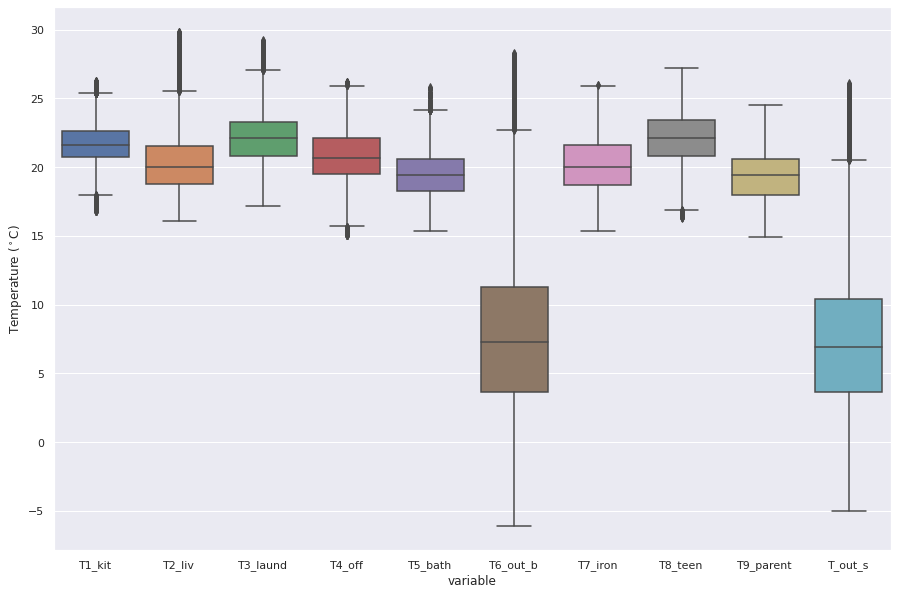

In [ ]:
df_melt = pd.melt(dataset.reset_index(), 'date', T_col)
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="variable", y="value", data=df_melt)
ax.set(ylabel='Temperature ($^\circ$C)')
plt.show()

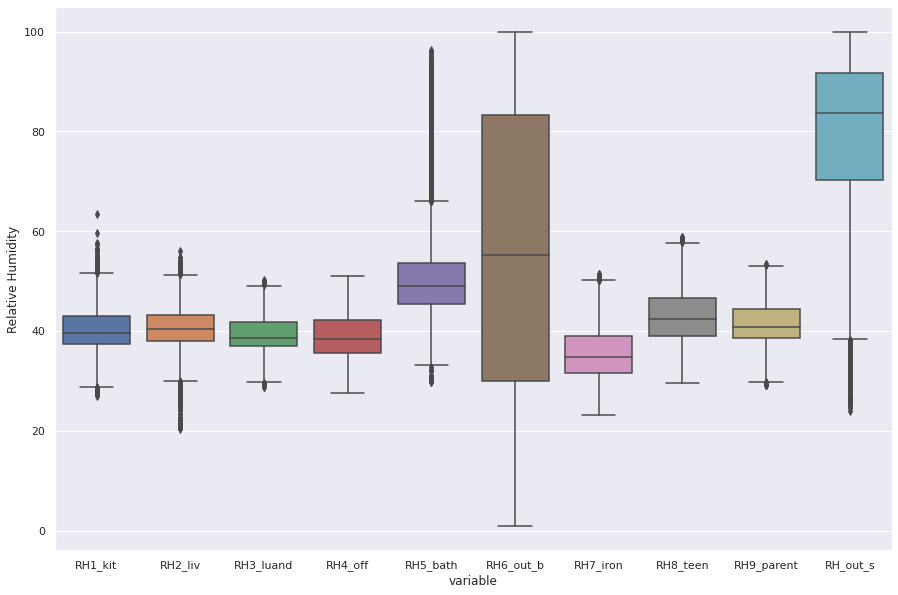

In [ ]:
df_melt = pd.melt(dataset.reset_index(), 'date', RH_col)
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="variable", y="value", data=df_melt)
ax.set(ylabel='Relative Humidity')
plt.show()

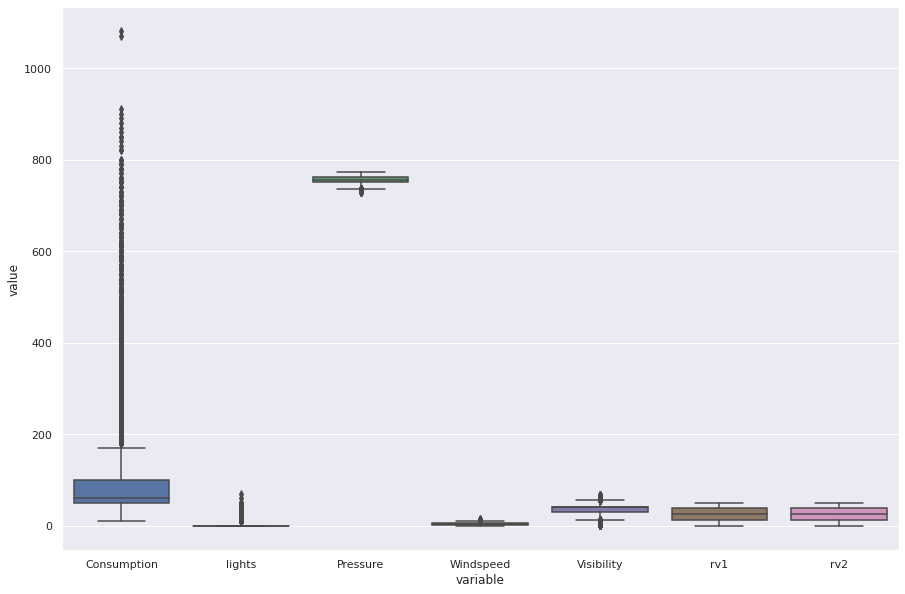

In [ ]:
df_melt = pd.melt(dataset.reset_index(), 'date', Rest_col)
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="variable", y="value", data=df_melt)
plt.show()

In [ ]:
dataset

,Consumption,lights,T1_kit,RH1_kit,T2_liv,RH2_liv,T3_laund,RH3_luand,T4_off,RH4_off,T5_bath,RH5_bath,T6_out_b,RH6_out_b,T7_iron,RH7_iron,T8_teen,RH8_teen,T9_parent,RH9_parent,T_out_s,Pressure,RH_out_s,Windspeed,Visibility,T_dew,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.60,19.20,44.79,19.79,44.73,19.00,45.57,17.17,55.20,7.03,84.26,17.20,41.63,18.20,48.90,17.03,45.53,6.60,733.50,92.00,7.00,63.00,5.30,13.28,13.28
2016-01-11 17:10:00,60,30,19.89,46.69,19.20,44.72,19.79,44.79,19.00,45.99,17.17,55.20,6.83,84.06,17.20,41.56,18.20,48.86,17.07,45.56,6.48,733.60,92.00,6.67,59.17,5.20,18.61,18.61
2016-01-11 17:20:00,50,30,19.89,46.30,19.20,44.63,19.79,44.93,18.93,45.89,17.17,55.09,6.56,83.16,17.20,41.43,18.20,48.73,17.00,45.50,6.37,733.70,92.00,6.33,55.33,5.10,28.64,28.64
2016-01-11 17:30:00,50,40,19.89,46.07,19.20,44.59,19.79,45.00,18.89,45.72,17.17,55.09,6.43,83.42,17.13,41.29,18.10,48.59,17.00,45.40,6.25,733.80,92.00,6.00,51.50,5.00,45.41,45.41
2016-01-11 17:40:00,60,40,19.89,46.33,19.20,44.53,19.79,45.00,18.89,45.53,17.20,55.09,6.37,84.89,17.20,41.23,18.10,48.59,17.00,45.40,6.13,733.90,92.00,5.67,47.67,4.90,10.08,10.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.20,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.20,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.20,56.33,3.67,25.33,13.27,29.20,29.20


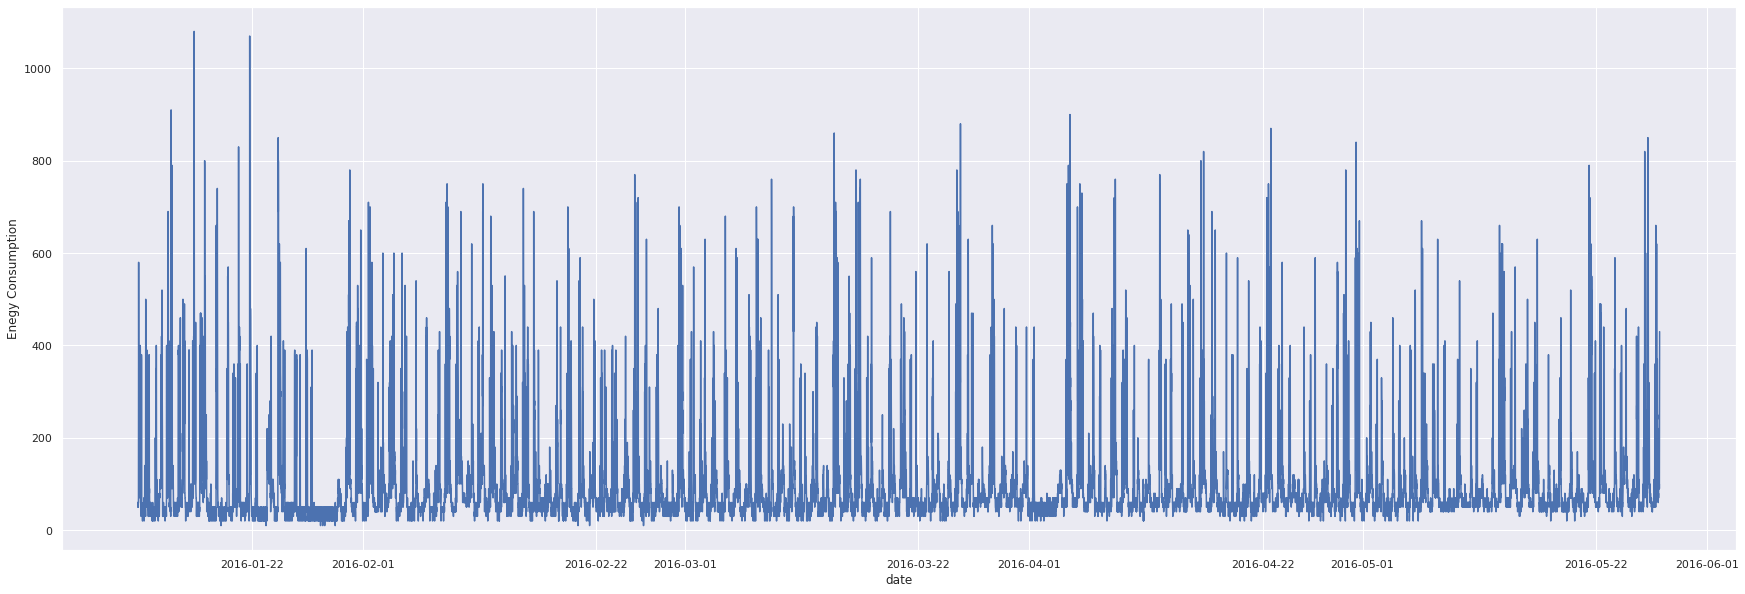

In [ ]:
plt.figure(figsize=(30,10))
ax = sns.lineplot(x=dataset.index, y=dataset['Consumption'])
ax.set(ylabel='Enegy Consumption')
plt.show()

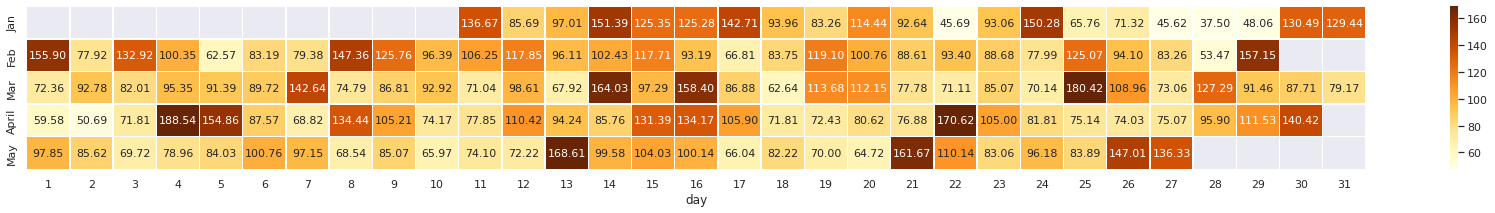

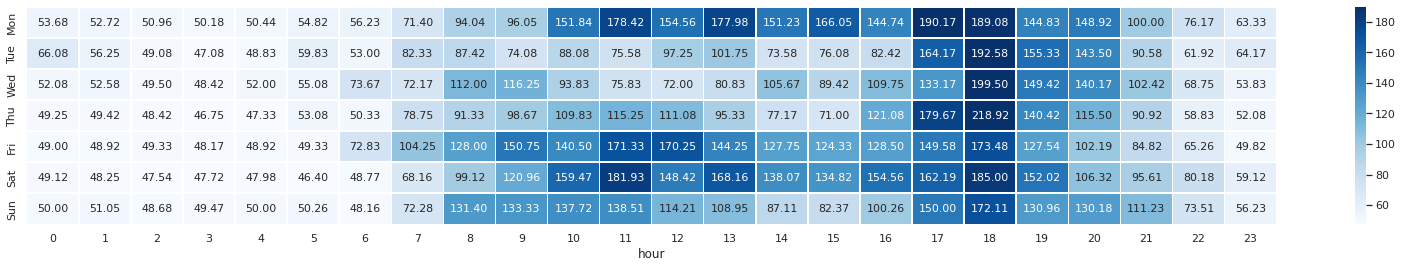

In [ ]:
heatmap_consump('Consumption')

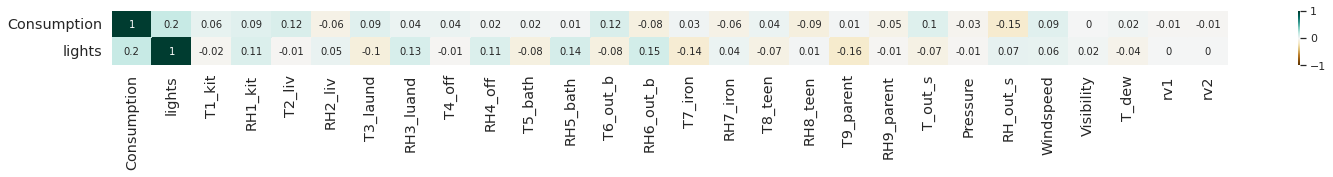

In [ ]:
corr_df = dataset.corr(method='pearson').round(2).iloc[:2, :]#.sort_values(by='Consumption', axis=1, ascending = False)
corr_heatmap(corr_df, (25,1))

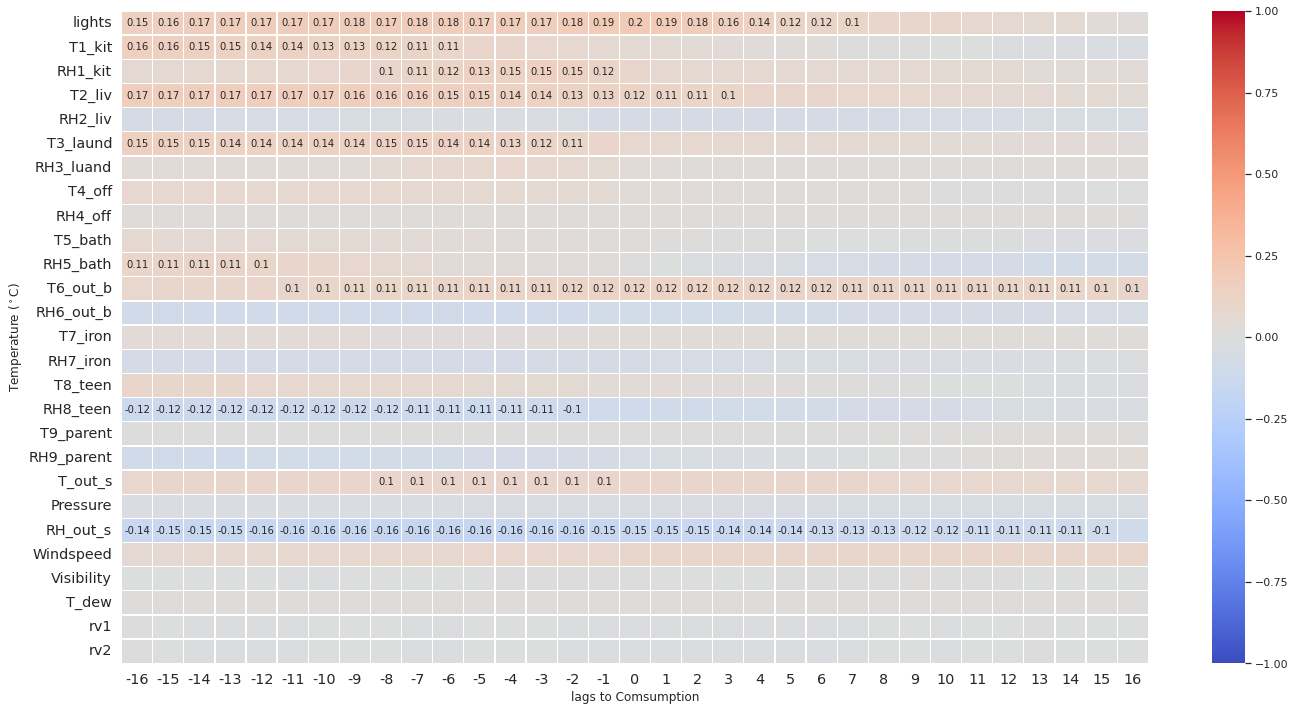

In [ ]:
cross_corr_heatmap(dataset)

# Select Importance Feature
cross-correlation อธิบาย

In [ ]:
selectedFeature = ['lights', 'RH1_kit', 'T2_liv', 'T6_out_b', 'RH8_teen', 'T_out_s', 'RH_out_s']
df = pd.DataFrame(dataset['Consumption']).copy()
# Extract time from datetime
df['month'] = [i.month for i in df.index]
df['day_of_week'] = [i.dayofweek for i in df.index]
df['hour'] = [i.hour for i in df.index]
df['minute'] = [i.minute for i in df.index]

# Select Important Features
df[selectedFeature] = dataset[selectedFeature]

# Cyclical Features
df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/24)) # month must begin at 0
df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/24)) # month must begin at 0
df['day_sin'] = np.sin(df['day_of_week']*(2.*np.pi/12))
df['day_cos'] = np.cos(df['day_of_week']*(2.*np.pi/12))
df['hour_sin'] = np.sin(df['hour'])*(2.*np.pi/12)
df['hour_cos'] = np.cos(df['hour'])*(2.*np.pi/12)
df['minute_sin'] = np.sin(df['minute'])*(2.*np.pi/12)
df['minute_cos'] = np.cos(df['minute'])*(2.*np.pi/12)
cyclical = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos','minute_sin', 'minute_cos']
df.head()

,Consumption,month,day_of_week,hour,minute,lights,RH1_kit,T2_liv,T6_out_b,RH8_teen,T_out_s,RH_out_s,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
date,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,1,0,17,0,30,47.596667,19.2,7.026667,48.900000,6.600000,92.0,0.0,1.0,0.0,1.0,-0.503387,-0.144075,0.000000,0.523599
2016-01-11 17:10:00,60,1,0,17,10,30,46.693333,19.2,6.833333,48.863333,6.483333,92.0,0.0,1.0,0.0,1.0,-0.503387,-0.144075,-0.284849,-0.439337
2016-01-11 17:20:00,50,1,0,17,20,30,46.300000,19.2,6.560000,48.730000,6.366667,92.0,0.0,1.0,0.0,1.0,-0.503387,-0.144075,0.478017,0.213671
2016-01-11 17:30:00,50,1,0,17,30,40,46.066667,19.2,6.433333,48.590000,6.250000,92.0,0.0,1.0,0.0,1.0,-0.503387,-0.144075,-0.517332,0.080766
2016-01-11 17:40:00,60,1,0,17,40,40,46.333333,19.2,6.366667,48.590000,6.133333,92.0,0.0,1.0,0.0,1.0,-0.503387,-0.144075,0.390140,-0.349208


# Baseline Model
- Use only Energy Consumption column to predict itself with datetime
- Use Energy Consumption columns with the importance features and datetime

http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [ ]:
def base_model(model,X,y):
  tscv = TimeSeriesSplit(n_splits=5)
  scores = cross_val_score(model, X_train, y_train, cv=tscv,
                          scoring='neg_root_mean_squared_error', n_jobs=-1)
  return scores

### Try using datetime to train the model

In [ ]:
# 6 models
models = [Pipeline([('scaler', MinMaxScaler()),('mlr', LinearRegression())]), 
          KNeighborsRegressor(n_neighbors=5),
          Pipeline([('scaler', MinMaxScaler()),('svr', SVR(kernel='rbf'))]),
          Pipeline([('scaler', MinMaxScaler()),
                    ('mlp', MLPRegressor((100,100), random_state=42, max_iter=500))]),
          RandomForestRegressor(),
          ExtraTreesRegressor(),
          GradientBoostingRegressor()]
results = []
for model in models:
  # Try using datetime to train the model
  X_train = df.iloc[:14803,:].index.values.reshape(-1,1)
  y_train = df.iloc[:14803,0].values
  results.append(base_model(model, X_train, y_train))

  # Try using 'month', 'day', 'hour', 'minute' columns extract from datetime
  X_train = df.iloc[:14803,1:5].values
  y_train = df.iloc[:14803,0].values
  results.append(base_model(model, X_train, y_train))

  # Try using sine and cosine, instead of datetime
  X_train = df.loc[:df.index[14802], cyclical].values
  y_train = df.iloc[:14803, 0].values
  results.append(base_model(model, X_train, y_train))

In [ ]:
df_rmse = pd.DataFrame(results, columns=[f'cv{i}' for i in range(1,6)],
                      index=['datetime_mlr','extract_mlr', 'cyclical_mlr',
                              'datetime_knn','extract_knn', 'cyclical_knn',
                              'datetime_svr','extract_svr', 'cyclical_svr',
                              'datetime_mlp','extract_mlp', 'cyclical_mlp',
                              'datetime_rf','extract_rf', 'cyclical_rf',
                              'datetime_et','extract_et', 'cyclical_et',
                              'datetime_gb','extract_gb', 'cyclical_gb']).round(2)
df_rmse

,cv1,cv2,cv3,cv4,cv5
datetime_mlr,-132.47,-96.73,-105.36,-103.16,-102.05
extract_mlr,-108.27,-96.80,-101.51,-100.49,-101.16
cyclical_mlr,-111.74,-333897967736825.31,-105.78,-102.38,-103.33
datetime_knn,-132.52,-103.09,-124.33,-113.40,-103.32
extract_knn,-117.19,-99.79,-97.95,-101.85,-109.77
cyclical_knn,-115.64,-99.36,-99.84,-103.59,-114.45
datetime_svr,-124.08,-98.90,-112.39,-110.08,-109.14
extract_svr,-116.97,-95.90,-107.41,-105.59,-107.58
cyclical_svr,-120.13,-100.49,-112.99,-110.36,-111.34
datetime_mlp,-121.69,-98.99,-105.20,-103.21,-102.16


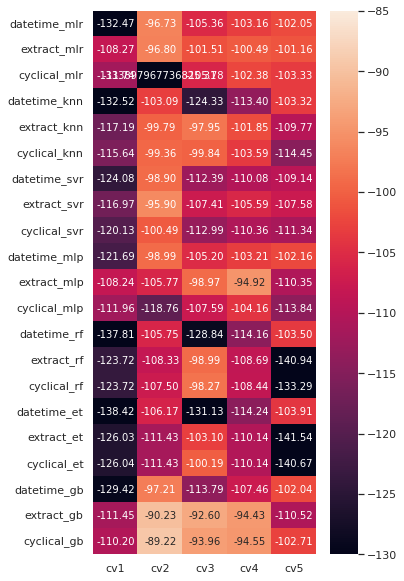

In [ ]:
plt.figure(figsize=(5,10))
ax = sns.heatmap(df_rmse,vmin=-85, vmax=-130, annot=True, fmt='.2f')
plt.show()

# Deep Learning (Long-Short Term Memeory)

# LSTM

In [ ]:
data_train = df.iloc[:14803, 0].values
scaler = MinMaxScaler()
data_train = data_train.reshape(-1,1)
scaler.fit(data_train)
data_train = scaler.transform(data_train)

In [ ]:
def create_X_y(dataset, windowSize):
  X, y = [], []
  for i in range(len(dataset)-windowSize):
    X.append(dataset[i:i+windowSize])
    y.append(dataset[i+windowSize])
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_X_y(data_train, 6*24)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (14659, 144, 1)
y_train shape:  (14659, 1)


In [ ]:
model = keras.Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 144, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Build the model 
model = keras.Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mean_absolute_error', 'mean_absolute_percentage_error'])
# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
1027/1027 [==============================] - 25s 18ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 34950.8594 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.0370 - val_mean_absolute_percentage_error: 58.0655
Epoch 2/20
1027/1027 [==============================] - 18s 17ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 26824.2051 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.0261 - val_mean_absolute_percentage_error: 25.4450
Epoch 3/20
1027/1027 [==============================] - 18s 17ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 28835.0586 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.0280 - val_mean_absolute_percentage_error: 35.2435
Epoch 4

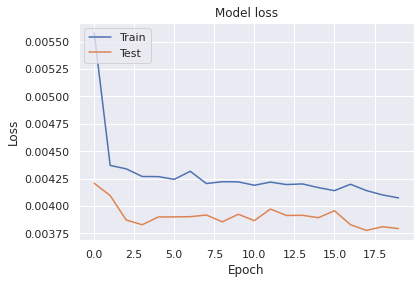

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
data_test = df.iloc[14803:, 0].values
data_test = data_test.reshape(-1,1)
data_test = scaler.transform(data_test)
X_test, y_test = create_X_y(data_test, 6*24)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (4788, 144, 1)
y_test shape:  (4788, 1)


In [ ]:
y_hat = model.predict(X_test)
y_predict = scaler.inverse_transform(y_hat)
y_actual = scaler.inverse_transform(y_test)

In [ ]:
y_hat.shape

(4788, 1)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
MSE = mean_squared_error(y_actual, y_predict)
RMSE = math.sqrt(MSE)
r2 = r2_score(y_actual, y_predict)
MAE = mean_absolute_error(y_actual, y_predict)
MAPE = MAE * 100
print('Root Mean Square Error: ', np.around(RMSE,2))
print('Mean Square Error: ', np.around(MSE,2))
print('R Square Error: ', np.around(r2,2))
print('Mean Absolute Error: ', np.around(MAE,2))
print('Mean Absolute Percentage Error: ', np.around(MAPE,2))

Root Mean Square Error:  57.72
Mean Square Error:  3332.01
R Square Error:  0.57
Mean Absolute Error:  28.8
Mean Absolute Percentage Error:  2879.73


In [ ]:
print('X_test shape: ', y_predict.shape)
print('y_test shape: ', y_actual.shape)

X_test shape:  (4788, 1)
y_test shape:  (4788, 1)


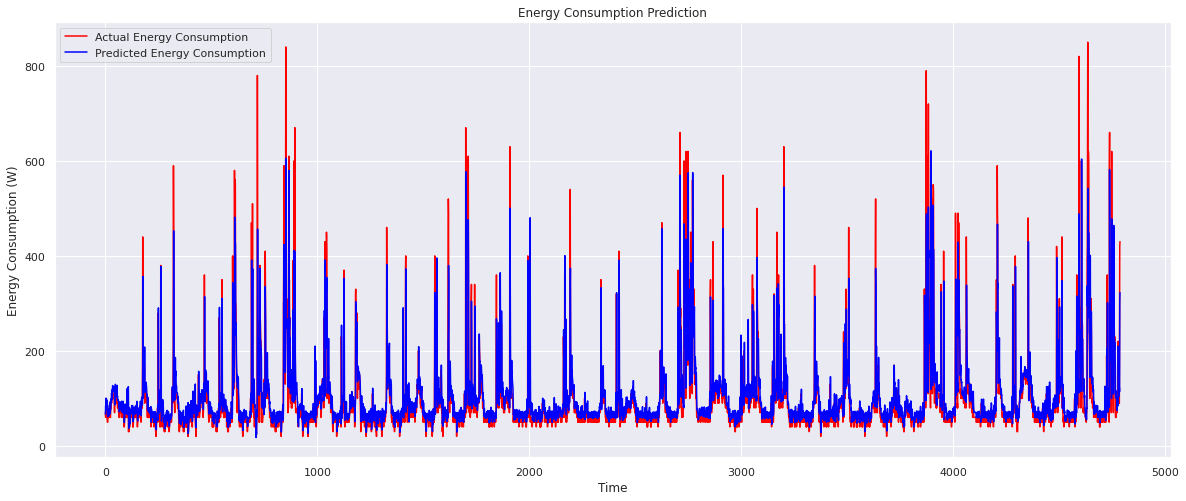

In [ ]:
# plot the results
plt.figure(figsize=(20,8))
plt.plot(y_actual, color = 'red', label = 'Actual Energy Consumption')
plt.plot(y_predict, color = 'blue', label = 'Predicted Energy Consumption')
plt.title('Energy Consumption Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (W)')
plt.legend()
plt.show()

In [ ]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Conv2D, MaxPool2D

In [ ]:
inputIm = Input(shape = (90,90,3,))
conv1 = Conv2D(20,5,activation='relu')(inputIm)
pool1 = MaxPool2D()


model = Model(inputs=inputIm, outputs=predictedW)

model.compile(optimizer=Adam(lr = 1e-4), loss='mse', metrics=['mean_absolute_error'])